### Now what's this all about? We're getting into the good stuff 
GSA is how we determine if the relationship between observations in a dataset is influenced by the similarity in geographic locations 
of these observations.
Spatial Autocorrelation can be compared to the temporal concept of Temporal Autocorrelation

Examples of phenomena that show positive spatial correlation: dist of income/poverty over space, 
Ex of neg.: supermarket spatial distrubutions -- they don't want to be too close!

### Global SA vs. Local SA
- Global SA is generally adressing the question of clustering. Are similar values more closely clustered togehter, spatially? Are they definitely more closely clustered than a random spatial distribution?
- Local SA is focused on the **deviations** from global trends, and has a generally smaller focus. 

In [1]:
# Exploratory Spatial Data Analysis (ESDA) time (fuck yeah)

In [7]:
# Let's talk about the EU!
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

In [8]:
brexit_data_path = "./brexit_vote.csv"
ref = pandas.read_csv(brexit_data_path, index_col="Area_Code")
lads = geopandas.read_file("./local_authority_districts.geojson").set_index("lad16cd")

In [9]:
db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"] # this is converting our coordinate ref. system (crs) to that normally used by webmaps
    ]
    .dropna()
)
db

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368..."
...,...,...,...,...
W06000018,385,Caerphilly,57.63,"POLYGON ((-367500.093 6763858.294, -368477.326..."
W06000019,386,Blaenau Gwent,62.03,"POLYGON ((-361591.484 6766770.434, -368477.326..."
W06000021,388,Monmouthshire,49.56,"MULTIPOLYGON (((-339763.135 6795234.133, -3414..."


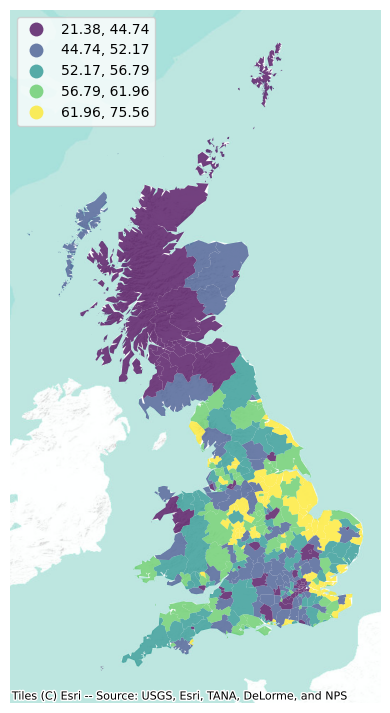

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

In [11]:
w = weights.KNN.from_dataframe(db, k=8)
w.transform = "R" #Row standardized weights 

Does the above map showcase any degree of positive GSA? It's hard to tell from the naked eye alone. This makes many choropleth maps hard to read with degree towwards GSA. To fix this, we need to use **indicators** of GSA -- statistical methods that tell us what is really happenning. 

#### The King of Indicators: **The Spatial Lag**
The product of Weights Matrix (W) and the vector of a given variable. 
In practice, this gives an explanation of a variable in the immidiate space around it. 
Think of spatial lag as having the average val of a given variable taken from a weighted group, so this will differ depending on the type of contiguity we use to define our group! (KNN, Queen etc.)
This is the bedrock of many spatial analysis techniques, and is driven by pysal.

In [12]:
db["Pct_Leave_lag"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)
db.loc[["E08000012", "S12000019"], ["Pct_Leave", "Pct_Leave_lag"]]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


Zooming in on two examples from above, the first being Liverpool, the second being Lidlothain, in Scotland. Both have similar `Pct_Leave` values, but viewing the spatial lag, Liverpool's `Pct_Leave` is influenced the surrounding areas which voted to Leave in higher numbers.  

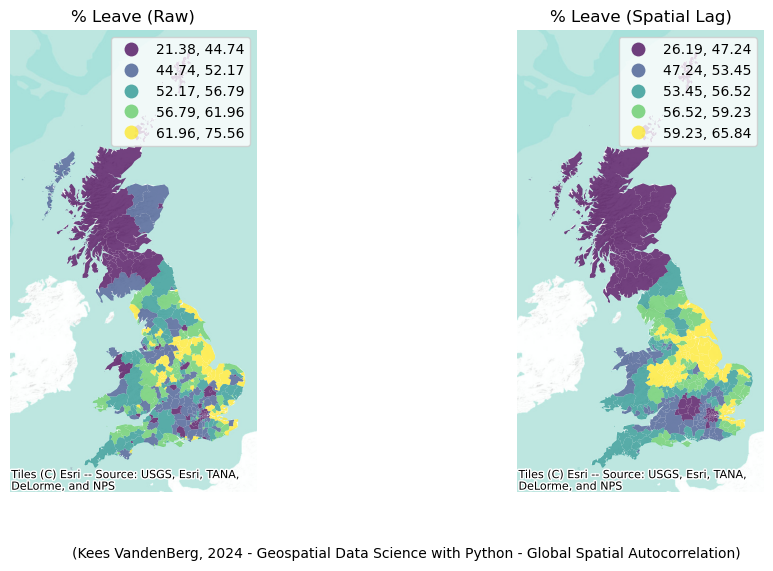

In [45]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% Leave (Raw)")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="Pct_Leave_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% Leave (Spatial Lag)")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.figtext(0.25, 0.00, '(Kees VandenBerg, 2024 - Geospatial Data Science with Python - Global Spatial Autocorrelation)', horizontalalignment='left')
plt.savefig("global_spatial_autocorrelation_uk.png", pad_inches=0.25, dpi=500, bbox_inches='tight')
plt.show()


Notice how the spatial lag diagram has less diffraction? Spatial Lag is also a local smoothing alg.
So: Now we have some ways to attach a variable to its geographic surroundings. 
#### Binary Values 


In [70]:
db["Leave"] = (db["Pct_Leave"] > 50).astype(int)

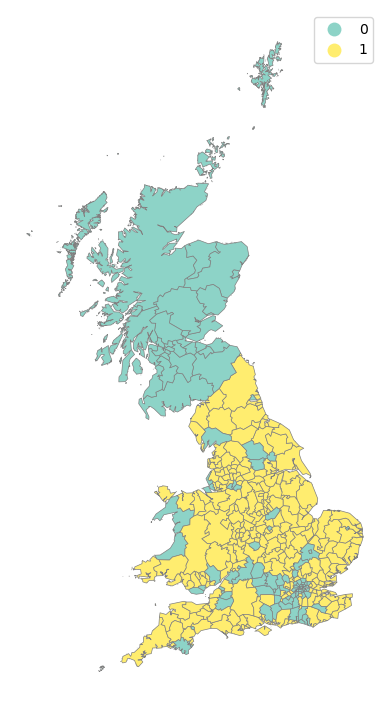

In [71]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    cmap="Set3",
    linewidth=0.5,
    edgecolor="0.5",
)
ax.set_axis_off()

Again, looking at the above with our visual monkey brains -- look pretty correlated. 
But lets be scientists about this whole thing and make a formal statistic.

### Joint count
Imagine a checkerboard w/t Green and Yellow squares. A JC has a count of the number of GG connections, YY connections and G/Y connections. In the context of a binary variable, seeing more GG/YY connections than GY connections would indicate a positive spatial autocorrelation, while the opposite would suggest the negative. 

In [72]:
w.transform = "O"

In [73]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["Leave"], w)


In [74]:
print(jc.bb) # number of black-black connections (bc this is origianlly black/white)
print(jc.ww)
print(jc.bw)
print(jc.J) # total number of joins

871.0
302.0
347.0
1520.0


In [79]:
# But how are we to derive if these values differ from random chance in any way? 
# esda has you covered: random spactial permutations of the observed values are used to generate p-values
# for the observed join counts, stored in the JC object. 
print(jc.p_sim_bb)
print(jc.p_sim_bw)

0.001
1.0


Looks like a clear case of potitive spatial Autocorrelation to me

### What if the Data's continuous? Moran Plot
This is one way to visualize the nature of spatial autocorrelation. This takes the form of a scatter plot that plots some variable of interest vs. it's spatial lag. The variable of interest is usually compared to the mean by adding or subtracting from the final val.

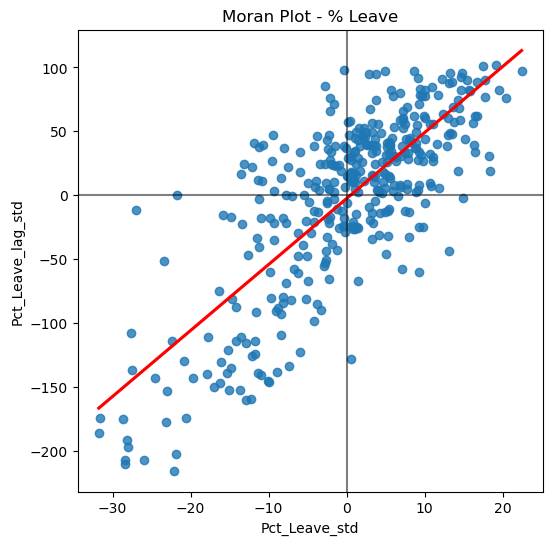

In [81]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["Pct_Leave_lag_std"] = weights.lag_spatial(
    w, db["Pct_Leave_std"]
)
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="Pct_Leave_std",
    y="Pct_Leave_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

The above positive trend line is evidence of positive spatial correlation -- if the lag vals were not moving with the normal vals at all, then that would be evidence that the general location of the observation had no impact on the variable measurement. 

If the **general** area of the observation has an effect on the observation, then they are spatially autocorrelated. 

The Moran plot is a good way to observe the clustering of data as well -- **Moran's I** is a formula that's meant to do exactly that. In the same way that the **mean** of a dataset seeks to capture some essence of a dataset's distribution in a single number, Moran's I looks to do the same for a spatial dataset --> it is basically the slope of the line of best fit on the graph above! 

In [82]:
w.transform = "R"
moran = esda.moran.Moran(db["Pct_Leave"], w)

In [84]:
moran.I #Moran I figure 

0.6454521298096587

In [85]:
# Again, we must ask the question, could this number arise from pure spatial randomness? 
# check the p sim... --> if this is small, we can reject the possibility
moran.p_sim

0.001

#### Just for fun...
What does the above value really mean? So if we had generated a large number of maps, and randomly distrubuted the values for `Pct_Leave` among the regions, and calculated Moran's I for each map, only 0.01% of the values generated wiould be larger than that found in the observed data. Meaning that, the real-life map of votes is more concentrated than if we were to randomly shuffle votes, thus being statistically significant. 